In [1]:
# Get all required packages
import ee
# from osgeo import gdal
# from pyproj import CRS
# import geemap as gm

import rioxarray as rio
import xarray as xr
import pandas as pd
import numpy as np

In [2]:
# Setup for Earth Engine
# ee.Authenticate()
ee.Initialize()

### Load data for analysis

Loading first some geometries to select regions

In [ ]:
import geopandas as gpd
from shapely.geometry import box

conts_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/continents.geojson'
north50_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/north50.geojson'
testrect_file = '/Users/moyanofe/Work/Augsburg/Research/LandCover/data/testrect.geojson'

conts = gpd.read_file(conts_file)
north50 = gpd.read_file(north50_file)
testrect = gpd.read_file(testrect_file)
conts_north50 = conts.clip(north50)
testarea = conts.clip(testrect)
# print(conts.crs)
# print(north50.crs)
# conts.plot()
# north50.plot()
testarea.plot()
# conts_north50.plot()

Loading here the co2 from inversion and doing some processing

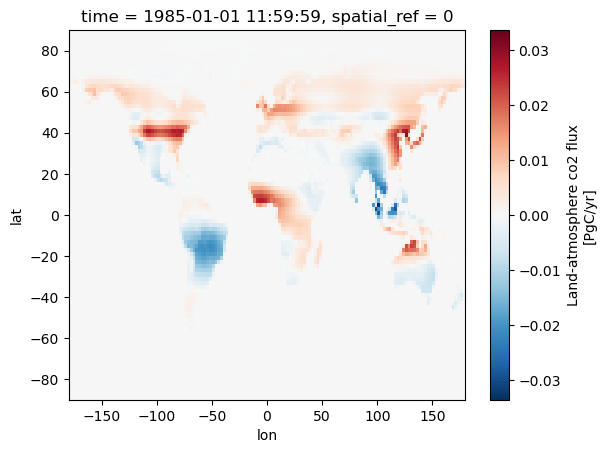

In [3]:
# Open data with Gdal and get the CRS information
# file_path = '/Users/moyanofe/BigData/GeoSpatial/Carboscope/Inversions/s85oc_v2022_daily.tiff'
file_path = '/Users/moyanofe/BigData/GeoSpatial/Carboscope/Inversions/s85oc_v2022_daily.nc'

# All three file reading methods read in the attributes differently.
# co2Inv = rio.open_rasterio(file_path)
# co2Inv = xr.open_dataset(file_path, engine="rasterio", variable='co2flux_land')
co2Inv_List = rio.open_rasterio(file_path, variable='co2flux_land')
co2Inv = co2Inv_List['co2flux_land']  # Extracting the dataarray from the list
co2Inv = co2Inv.rename({'mtime': 'time'})  # Rename the time dimension and coordinate to something standard.
co2Inv = co2Inv.rename({'x': 'lon'})  # Rename the time dimension and coordinate to something standard.
co2Inv = co2Inv.rename({'y': 'lat'})  # Rename the time dimension and coordinate to something standard.
co2Inv.attrs['units'] = 'PgC/yr'  # For some reason the units is a tuple of repeating values. Replacing with single value.
co2Inv[0].plot()
# co2Inv = co2Inv.reindex({'lat':co2Inv.lat[::-1]})  # Reindexing not necessary. Did open rasterio 
# rasplot.show(co2Inv[0])


In [4]:
months = co2Inv.time.dt.month.data
# season = np.where(np.logical_or(months < 4, months > 9), 0, 1)
season = np.where((months < 4) | (months > 9), 0, 1)
groups = co2Inv.time.dt.year.data + (season/10)
co2Inv['groups'] = ('time', groups)
# co2Inv['season'] = ('time', season)



In [ ]:
co2Inv.groups[0:400]

In [6]:
# co2InvS = co2Inv.groupby(['time.year', 'season']).mean()  # grouping by two variables is not supported in xarray!
co2InvG = co2Inv.groupby('groups').mean()

In [ ]:
for i in range(0,100):
    
# co2InvG.groupby('time.year').

### After loading data, we need to preprocess it to get it ready for analysis

#### Apply same crs to all data

Let's use the common WGS84: EPSG 4326. This should be set to all rasters used. If the crs was WGS84 but the property was not set, thenn use:  
`mydata.rio.write_crs("epsg:4326", inplace=True)`  

Else, change the crs with   
`mydata.rio.reproject("EPSG:4326")`  

When adding more datasets, these can be adjusted to the first using:  
`mydata2 = mydata2.rio.reproject_match(mydata)`  



#### Set a missing data value

Set a missing data value to be same across all data, e.g. -9999.   

`mydata.rio.set_nodata(-9999, inplace=True)` # will set the nadata attrribute without modifying the data
`mydata.rio.write_nodata(-9999, inplace=True)` # will write to the array (I guess replacing the existing missing data value?) Need to test.  

Note that the reproject_match method from above will modify the nodata value of mydata2 to match that of mydata.  

Use the following to mask the missing data:  
```
nodata = raster.rio.nodata
raster = raster.where(raster != nodata)
raster.rio.write_nodata(nodata, encoded=True, inplace=True)
```


#### 3. Create geometry objects to mask/filter the data, e.g. continents, above 50N, ecoregions

In [ ]:
# Clipping only for the test area
inv_co2_test = inv_co2.rio.clip(testarea.geometry, testarea.crs)
# plot to check the output
inv_co2_test[0].plot()

### CO2 flux analysis

*Do the easy approach first, selecting for months and not fitting a harmonic:*
- Loop over years
- Per year choose growing season months
- Get the flux sum
- Repeat for the non winter months
- Get the difference between both and store as raster

In [ ]:
inv_co2_test
